In [7]:
import ee
import numpy as np
import xarray as xr
import json
import geemap

In [2]:
# Initialize the Earth Engine Python API
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [4]:
from anomaly_processing import anomaly_processing

gee_image = anomaly_processing(
                            'Arkhangai',
                            'Chuluut',
                            'NDVI',
                            '2023',
                            True
                        )

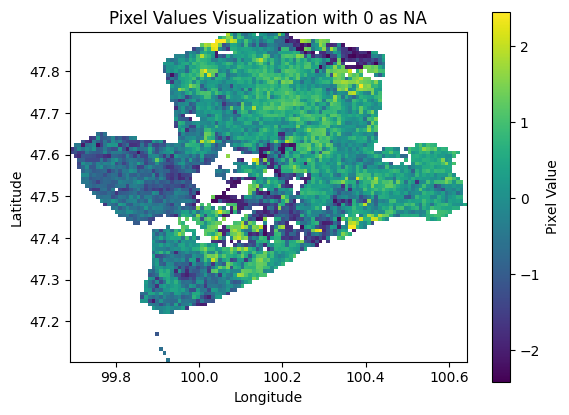

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Sample data (replace this with your actual Google Earth Engine Image data)
# Get the latlon image
latlon = ee.Image.pixelLonLat().addBands(gee_image)

# Get the coordinates and pixel values using latlon image
latlon_data = latlon.unmask().reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=gee_image.geometry(),
    maxPixels=1e13,
    scale=1000
)

# Extract the pixel values, latitudes, and longitudes from the latlon_data dictionary
pixel_values = np.array(latlon_data.get('z_score').getInfo())
lats = np.array(latlon_data.get('latitude').getInfo())
lons = np.array(latlon_data.get('longitude').getInfo())

# Get unique latitudes and longitudes
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)
ncols = len(uniqueLons)
nrows = len(uniqueLats)

# # Create a 2D array with NaN values to store the pixel values in a grid
# arr = np.full((nrows, ncols), np.nan, dtype=np.float32)

# # # Calculate the linear index corresponding to each latitude and longitude pair
# # y_indices = np.searchsorted(uniqueLats, lats)
# # x_indices = np.searchsorted(uniqueLons, lons)

# # Assign pixel values to the arr array using linear indexing
# arr[y_indices, x_indices] = pixel_values

# # Create an xarray DataArray using the grid and the pixel values numpy array
# da_z_score = xr.DataArray(arr, coords=[uniqueLats, uniqueLons], dims=['latitude', 'longitude'])

# # Set 0 as NA (Not a Number) for the z-score band in the DataArray
# da_z_score = da_z_score.where(da_z_score != 0, np.nan)

# Calculate the linear index corresponding to each latitude and longitude pair
y_indices = np.digitize(lats, uniqueLats) - 1
x_indices = np.digitize(lons, uniqueLons) - 1

# Create a 2D array with NaN values to store the pixel values in a grid
arr = np.full((nrows, ncols), np.nan, dtype=np.float32)

# Assign pixel values to the arr array using linear indexing
arr[y_indices, x_indices] = pixel_values

# Create an xarray DataArray using the grid and the pixel values numpy array
da_z_score = xr.DataArray(arr, coords=[uniqueLats, uniqueLons], dims=['latitude', 'longitude'])

# Set 0 as NA (Not a Number) for the z-score band in the DataArray
da_z_score = da_z_score.where(da_z_score != 0, np.nan)

# Plot the DataArray with 0 as NA
plt.imshow(da_z_score, cmap='viridis', extent=[uniqueLons.min(), uniqueLons.max(), uniqueLats.min(), uniqueLats.max()], origin='lower')
plt.colorbar(label='Pixel Value')  # Add a colorbar with pixel values
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pixel Values Visualization with 0 as NA')
plt.show()

In [6]:
da_z_score

<xarray.DataArray (latitude: 89, longitude: 107)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 47.1 47.11 47.12 47.13 ... 47.88 47.88 47.89
  * longitude  (longitude) float64 99.69 99.7 99.71 99.72 ... 100.6 100.6 100.6

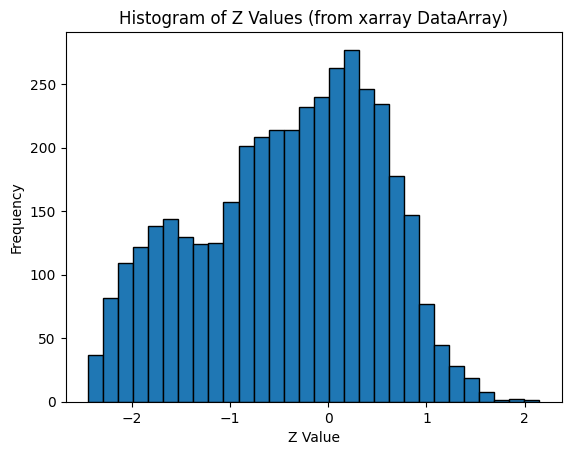

In [5]:
# Plot the histogram
da_z_score.plot.hist(bins=30, edgecolor='black')
plt.xlabel('Z Value')
plt.ylabel('Frequency')
plt.title('Histogram of Z Values (from xarray DataArray)')
plt.show()

In [11]:
anomParams = {'min': -3, 'max':3, 'palette': ['red', 'yellow', 'green']}

In [12]:
Map = geemap.Map()
Map.addLayer(gee_image, anomParams, 'test nmap')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [15]:
def convert_gee_image_to_geojson(gee_image):

    # Sample data (replace this with your actual Google Earth Engine Image data)
    # Get the latlon image
    latlon = ee.Image.pixelLonLat().addBands(gee_image)

    # Get the coordinates and pixel values using latlon image
    latlon_data = latlon.unmask().reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=gee_image.geometry(),
        maxPixels=1e13,
        scale=1000
    )

    # Extract the pixel values, latitudes, and longitudes from the latlon_data dictionary
    pixel_values = np.array(latlon_data.get('z_score').getInfo())
    lats = np.array(latlon_data.get('latitude').getInfo())
    lons = np.array(latlon_data.get('longitude').getInfo())

    # Get unique latitudes and longitudes
    # uniqueLats = np.unique(lats)
    # uniqueLons = np.unique(lons)

    # Create a list of features for GeoJSON
    features = []
    for i in range(len(pixel_values)):
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [lons[i], lats[i]]
            },
            "properties": {
                "z_score": pixel_values[i]
            }
        }
        features.append(feature)

    # Create the GeoJSON data as a dictionary
    geojson_data = {
        "type": "FeatureCollection",
        "features": features
    }

    print(type(geojson_data))
    # Convert GeoJSON data to JSON string
    geojson_json_str = json.dumps(geojson_data)
    print(type(geojson_string))
    return geojson_json_str

# Test
geojson_string = convert_gee_image_to_geojson(gee_image)
print(geojson_string)

<class 'dict'>
<class 'str'>
{"type": "FeatureCollection", "features": [{"type": "Feature", "geometry": {"type": "Point", "coordinates": [99.92410062903498, 47.10316192280711]}, "properties": {"z_score": -0.4971764263537396}}, {"type": "Feature", "geometry": {"type": "Point", "coordinates": [99.93308378187618, 47.10316192280711]}, "properties": {"z_score": 0.0}}, {"type": "Feature", "geometry": {"type": "Point", "coordinates": [99.94206693471737, 47.10316192280711]}, "properties": {"z_score": 0.0}}, {"type": "Feature", "geometry": {"type": "Point", "coordinates": [99.95105008755857, 47.10316192280711]}, "properties": {"z_score": 0.0}}, {"type": "Feature", "geometry": {"type": "Point", "coordinates": [99.96003324039975, 47.10316192280711]}, "properties": {"z_score": 0.0}}, {"type": "Feature", "geometry": {"type": "Point", "coordinates": [99.97799954608215, 47.10316192280711]}, "properties": {"z_score": 0.0}}, {"type": "Feature", "geometry": {"type": "Point", "coordinates": [99.986982698

In [13]:
type(geojson_string)

str

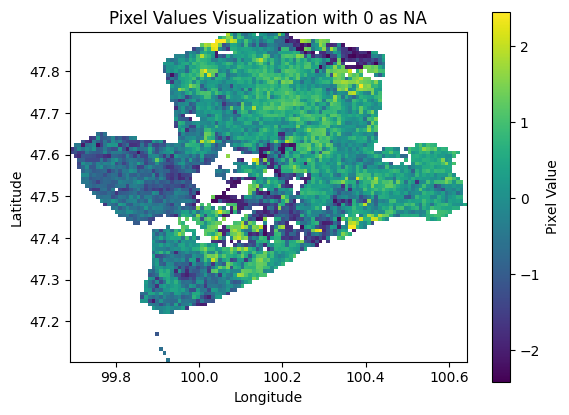

In [12]:
# Parse the GeoJSON string
geojson_data = json.loads(geojson_string)

# Extract latitude, longitude, and pixel values from the GeoJSON data
lats = []
lons = []
pixel_values = []
for feature in geojson_data['features']:
    lon, lat = feature['geometry']['coordinates']
    lats.append(lat)
    lons.append(lon)
    pixel_values.append(feature['properties']['z_score'])

# Get unique latitudes and longitudes
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)
ncols = len(uniqueLons)
nrows = len(uniqueLats)

# Create a 2D array with NaN values to store the pixel values in a grid
arr = np.full((nrows, ncols), np.nan, dtype=np.float32)

# Calculate the linear index corresponding to each latitude and longitude pair
y_indices = np.digitize(lats, uniqueLats) - 1
x_indices = np.digitize(lons, uniqueLons) - 1

# Assign pixel values to the arr array using linear indexing
arr[y_indices, x_indices] = pixel_values

# Create an xarray DataArray using the grid and the pixel values numpy array
da_z_score = xr.DataArray(arr, coords=[uniqueLats, uniqueLons], dims=['latitude', 'longitude'])

# Set 0 as NA (Not a Number) for the z-score band in the DataArray
da_z_score = da_z_score.where(da_z_score != 0, np.nan)

# Plot the DataArray with 0 as NA
plt.imshow(da_z_score, cmap='viridis', extent=[uniqueLons.min(), uniqueLons.max(), uniqueLats.min(), uniqueLats.max()], origin='lower')
plt.colorbar(label='Pixel Value')  # Add a colorbar with pixel values
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pixel Values Visualization with 0 as NA')
plt.show()